# Dirichlet example from Maier

Based on http://dirichletreg.r-forge.r-project.org/


In [124]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import ternary
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os
import arviz as az
from matplotlib.patches import Ellipse, transforms
from itertools import combinations
#import ternary

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

Dataset are proportion of nutrient productivity by fish functional groups, for calcium.mg

In [134]:
# Import data
nut = pd.read_csv("zinc.mg_scaled.csv")
nut.head()

y = nut[["herbivore-detritivore","herbivore-macroalgae","invertivore-mobile","omnivore","piscivore","planktivore"]]
# Grab fg names
hnames = list(y[:-1])

y = y.to_numpy()
nfg = y.shape[1]

# identify predictors
hc = nut.hard_coral.to_numpy()
# ma = nut.macroalgae.to_numpy()
grav_nc = nut.grav_nc.to_numpy()
depth = nut.depth.to_numpy()



And the code to bulid the model in PyMC is relatively straightforward

In [135]:
with pm.Model() as BDM:
    intercept = pm.Normal('intercept', 0, 2, shape=nfg)
    hard_coral = pm.Normal('hard_coral', 0, 0.5, shape=nfg)
    gravity = pm.Normal('gravity', 0, 1, shape=nfg)
    dep = pm.Normal('dep', 0, 0.5, shape=nfg)

    α = pm.Deterministic('alpha', tt.exp(intercept+hard_coral*hc[:,None]+
                                         gravity*grav_nc[:,None] +
                                         dep*depth[:,None]))
    Yi = pm.Dirichlet('Yi', α, observed=y)

Note the `[:,None]` in the code is to broadcast the predictor measurements across all fish functional groups.

In [136]:
for RV in BDM.basic_RVs:
    print(RV.name, RV.logp(BDM.test_point))

intercept -9.672514282587708
hard_coral -1.3547481158683645
gravity -5.513631199228035
dep -1.3547481158683645
Yi 1910.2092053700499


In [137]:
with BDM:
    trace_dm = pm.sample()

/opt/miniconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'intercept': array([-0.42170992,  0.4645099 ,  0.19766803, -0.67920754,  0.5032996 ,
       -0.58511566]), 'hard_coral': array([ 0.70962821, -0.21013709, -0.87219838,  0.96971746, -0.03894913,
       -0.47131465]), 'gravity': array([ 0.38903861, -0.07698696,  0.15276096, -0.95544901,  0.34097991,
       -0.3701268 ]), 'dep': array([ 0.86757378,  0.12801259, -0.95864263,  0.52619768,  0.70875743,
        0.77081805])}

Initial evaluation results:
intercept    -9.86
hard_coral   -6.30
gravity      -6.19
dep          -7.48
Yi            -inf
Name: Log-probability of test_point, dtype: float64

In [38]:
pm.traceplot(trace_dm);

NameError: name 'trace_dm' is not defined

In [ ]:
pm.summary(trace_dm, var_names=['intercept', 'depth', 'depth2'])

In [ ]:
# Grab alphas
alpha = trace_dm['alpha'].T
alpha_0 = alpha.sum(0).mean(1)

In [ ]:
# Grab expected alphas
Ex_alphas = alpha.mean(2)
Ex = Ex_alphas/alpha_0

NameError: name 'Ex' is not defined

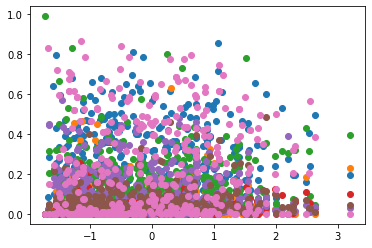

In [43]:
# Plot estimates against observed
[plt.scatter(hc,yi,label=l) for yi,l in zip(y.T,hnames)]
[plt.plot(hc,ei) for ei in Ex]
plt.ylabel('Expected proportions', fontsize=15)
plt.xlabel('Depth (z-score)', fontsize=15)
plt.legend();

The plot above of the expected change in proportions with depth looks great - but this is on the probability scale, abd these lines wiggle quite a lot given that the underlying model is a second order polynomial. How is this possible? Well the lines are relative to one another based on the simplex (i.e. that they all sum to one), and their expectation is a ratio relative to the total sum:

$$
E(y_i) = \frac{\alpha_i}{\alpha_0}
$$


To see what the underlying polynomials look like (on the $[0,\infty]$ scale) we can look at the alphas against depth:

In [ ]:
# Plot alphas vs depth
plt.plot(DEP, alpha_0, linestyle='--', c='black', label='α0')
[plt.plot(DEP, a, label='α-'+l) for a,l in zip(Ex_alphas,hnames)]
plt.ylabel('αi', fontsize=15)
plt.xlabel('Depth (z-score)', fontsize=15)
plt.legend();